## Chapter 10 - Model Comparision and Hierarchical Modelling

- [10.3.2 - Hierarchical MCMC computation of relative model probability (Two factories of coins)](#10.3.2---Hierarchical-MCMC-computation-of-relative-model-probability)
 - [Model 1 - One theta variable ](#Model-1---One-theta-variable)
 - [Model 2 - Two theta variables without pseudo priors](#Model-2---Two-theta-variables-without-pseudo-priors)
 - [Model 3 - Two theta variables with pseudo priors = true prior](#Model-3---Two-theta-variables-with-pseudo-priors-=-true-prior)
 - [Model 4 - Two theta variables with pseudo priors that mimic posteriors ](#Model-4---Two-theta-variables-with-pseudo-priors-that-mimic-posteriors)

In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from aesara.tensor import eq
from IPython.display import Image
from matplotlib import gridspec

%matplotlib inline
plt.style.use('seaborn-white')

color = '#87ceeb'

In [2]:
%load_ext watermark
%watermark -p pandas,numpy,pymc3,matplotlib,seaborn,theano

pandas    : 1.3.5
numpy     : 1.22.0
pymc3     : not installed
matplotlib: 3.5.1
seaborn   : 0.11.2
theano    : not installed



### 10.3.2 - Hierarchical MCMC computation of relative model probability

#### Model (Kruschke, 2015)

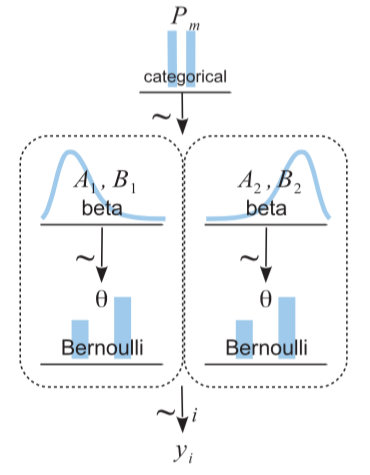

In [3]:
Image('images/fig10_2.png', width=300)

### Model 1 - One theta variable 
Coin is flipped nine times, resulting in six heads.

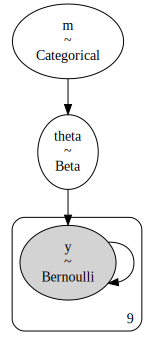

In [4]:
with pm.Model() as hierarchical_model:
    m = pm.Categorical('m', np.asarray([.5, .5]))
    
    kappa = 12
    
    omega = pm.math.switch(eq(m, 0), .25, .75)
    
    theta = pm.Beta('theta', omega*(kappa-2)+1, (1-omega)*(kappa-2)+1)
    
    y = pm.Bernoulli('y', theta, observed=[1,1,1,1,1,1,0,0,0])

pm.model_to_graphviz(hierarchical_model)

In [5]:
with hierarchical_model:
    idata = pm.sample(5000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>BinaryGibbsMetropolis: [m]
>NUTS: [theta]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 7 seconds.
The number of effective samples is smaller than 25% for some parameters.


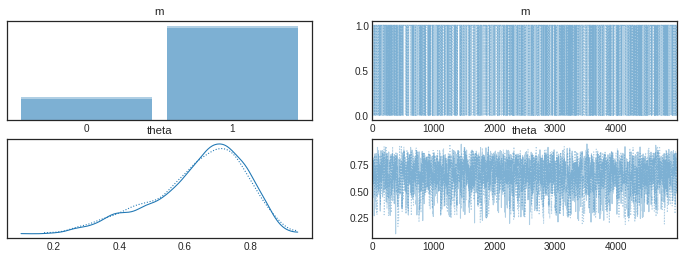

In [6]:
az.plot_trace(idata);

In [7]:
trace_df = idata.posterior.to_dataframe().set_index('m')
trace_df.head()

,theta
m,
1,0.790107
1,0.681944
1,0.690533
1,0.690533
1,0.726161


#### Figure 10.4 (lower frame)
Note that the models are indexed starting with 0 and not 1, as is the case in Kruschke (2015). So the posterior mean of parameter `m` is shifted with -1.

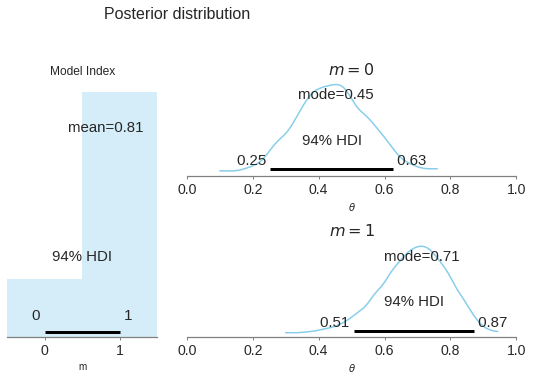

In [8]:
fig = plt.figure(figsize=(10,5))

font_d = {'size':16}

# Define gridspec
gs = gridspec.GridSpec(2, 4)
ax1 = plt.subplot(gs[0:,1])
ax2 = plt.subplot(gs[0,2:])
ax3 = plt.subplot(gs[1,2:])

# Distplot m
az.plot_posterior(np.asarray(trace_df.index), ax=ax1, color=color)
ax1.set_xlabel('m')
ax1.set_title('Model Index')

# Distplot theta for m=0 and m=1 
for model, ax in zip((0,1), (ax2, ax3)):
    az.plot_posterior(trace_df.loc[model].values.ravel(), point_estimate='mode', ax=ax, color=color)
    ax.set_title(r'$m = {}$'.format(model), fontdict=font_d)    
    ax.set(xlim=(0,1), xlabel=r'$\theta$')

fig.suptitle('Posterior distribution', size=16, y=1.05)
    
fig.tight_layout(w_pad=2);

### Model 2 - Two theta variables without pseudo priors
Coin is flipped nine times, resulting in six heads.

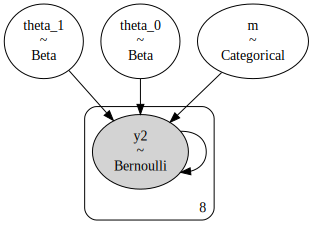

In [9]:
with pm.Model() as hierarchical_model2:
    m = pm.Categorical('m', np.asarray([.5, .5]))
    
    omega_0 = .25
    kappa_0 = 12
    theta_0 = pm.Beta('theta_0', omega_0*(kappa_0-2)+1, (1-omega_0)*(kappa_0-2)+1)
    
    omega_1 = .75
    kappa_1 = 12
    theta_1 = pm.Beta('theta_1', omega_1*(kappa_1-2)+1, (1-omega_1)*(kappa_1-2)+1)
    
    theta = pm.math.switch(eq(m, 0), theta_0, theta_1)
    
    y2 = pm.Bernoulli('y2', theta, observed=[1,1,1,1,1,0,0,0])

pm.model_to_graphviz(hierarchical_model2)

In [10]:
with hierarchical_model2:
    idata2 = pm.sample(5000, cores=4)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [m]
>NUTS: [theta_0, theta_1]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 24 seconds.


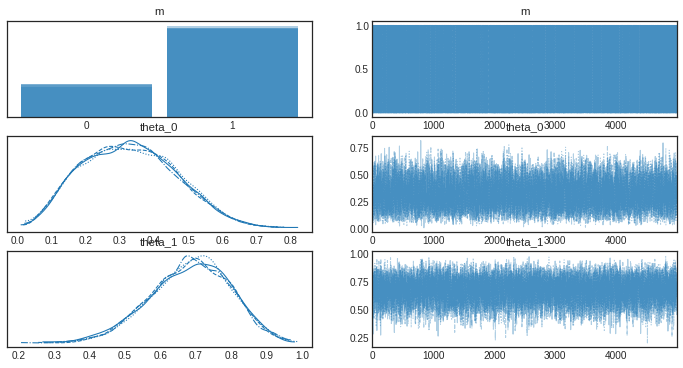

In [11]:
az.plot_trace(idata2);

### Model 3 - Two theta variables with pseudo priors = true prior
Coin is flipped 30 times, resulting in 17 heads.

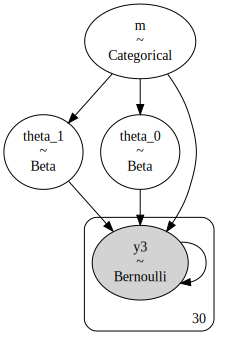

In [12]:
with pm.Model() as hierarchical_model3:
    m = pm.Categorical('m', np.asarray([.5, .5]))
    
    # Theta0
    kappa_0_true_p = 20
    kappa_0_pseudo_p = 20
    kappa_0 = pm.math.switch(eq(m, 0), kappa_0_true_p, kappa_0_pseudo_p)
    omega_0_true_p = .10
    omega_0_pseudo_p = .10
    omega_0 = pm.math.switch(eq(m, 0), omega_0_true_p, omega_0_pseudo_p)
    theta_0 = pm.Beta('theta_0', omega_0*(kappa_0-2)+1, (1-omega_0)*(kappa_0-2)+1)
    
    # Theta1    
    kappa_1_true_p = 20
    kappa_1_pseudo_p = 20 
    kappa_1 = pm.math.switch(eq(m, 1), kappa_1_true_p, kappa_1_pseudo_p)
    omega_1_true_p = .90
    omega_1_pseudo_p = .90
    omega_1 = pm.math.switch(eq(m, 1), omega_1_true_p, omega_1_pseudo_p)
    theta_1 = pm.Beta('theta_1', omega_1*(kappa_1-2)+1, (1-omega_1)*(kappa_1-2)+1)
    
    theta = pm.math.switch(eq(m, 0), theta_0, theta_1)
    
    y3 = pm.Bernoulli('y3', theta, observed=np.r_[17*[1], 13*[0]])

pm.model_to_graphviz(hierarchical_model3)

In [13]:
with hierarchical_model3:
    idata3 = pm.sample(5000, tune=10000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>BinaryGibbsMetropolis: [m]
>NUTS: [theta_0, theta_1]


Sampling 2 chains for 10_000 tune and 5_000 draw iterations (20_000 + 10_000 draws total) took 23 seconds.
The acceptance probability does not match the target. It is 0.3238, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6403, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


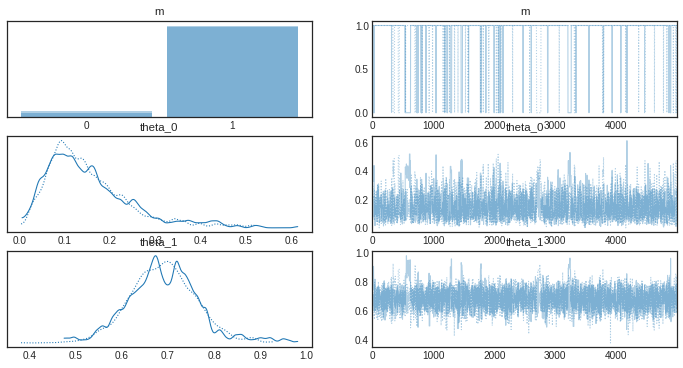

In [14]:
az.plot_trace(idata3);

In [15]:
trace3_df = idata3.posterior.to_dataframe().set_index('m')[['theta_0', 'theta_1']]
trace3_df.head()

,theta_0,theta_1
m,,
1,0.175455,0.760242
1,0.145340,0.599551
1,0.234574,0.711545
1,0.358476,0.633627
1,0.358476,0.633627


#### Figure 10.5 (lower part)

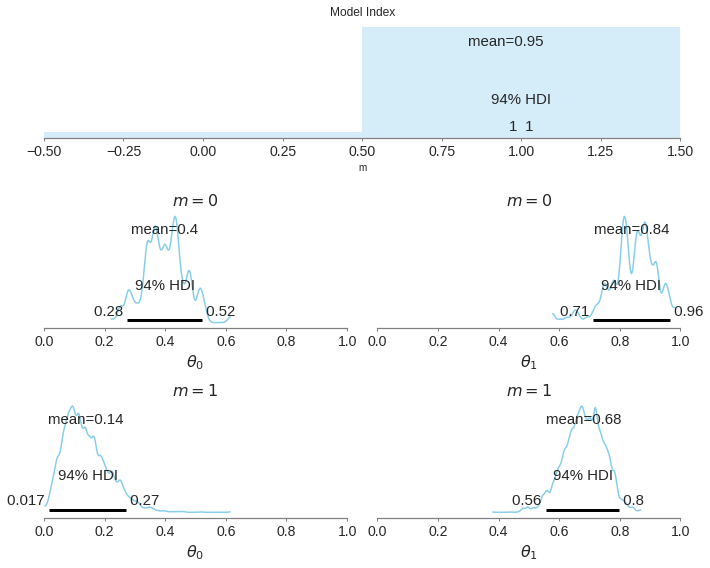

In [16]:
fig = plt.figure(figsize=(10,8))

# Define gridspec
gs = gridspec.GridSpec(3,2)
ax1 = plt.subplot(gs[0,:])
ax2 = plt.subplot(gs[1,0])
ax3 = plt.subplot(gs[1,1])
ax4 = plt.subplot(gs[2,0])
ax5 = plt.subplot(gs[2,1])

az.plot_posterior(np.asarray(trace3_df.index), ax=ax1, color=color)
ax1.set_xlabel('m')
ax1.set_title('Model Index')

for model, theta, ax in zip((0,0,1,1), (0,1,0,1), (ax2, ax3, ax4, ax5)):
    az.plot_posterior(trace3_df.loc[model, 'theta_{}'.format(theta)].values, ax=ax, color=color)
    ax.set_title(r'$m = {}$'.format(model), fontdict=font_d)
    ax.set_xlim(0,1)
    ax.set_xlabel(r'$\theta_{}$'.format(theta), fontdict=font_d)
    
fig.tight_layout();

### Model 4 - Two theta variables with pseudo priors that mimic posteriors 
Coin is flipped 30 times, resulting in 17 heads.

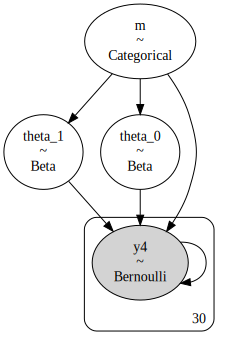

In [17]:
with pm.Model() as hierarchical_model4:
    m = pm.Categorical('m', np.asarray([.5, .5]))
    
    # Theta0
    kappa_0_true_p = 20
    kappa_0_pseudo_p = 50
    kappa_0 = pm.math.switch(eq(m, 0), kappa_0_true_p, kappa_0_pseudo_p)
    omega_0_true_p = .10
    omega_0_pseudo_p = .40
    omega_0 = pm.math.switch(eq(m, 0), omega_0_true_p, omega_0_pseudo_p)
    theta_0 = pm.Beta('theta_0', omega_0*(kappa_0-2)+1, (1-omega_0)*(kappa_0-2)+1)
    
    # Theta1    
    kappa_1_true_p = 20
    kappa_1_pseudo_p = 50 
    kappa_1 = pm.math.switch(eq(m, 1), kappa_1_true_p, kappa_1_pseudo_p)
    omega_1_true_p = .90
    omega_1_pseudo_p = .70
    omega_1 = pm.math.switch(eq(m, 1), omega_1_true_p, omega_1_pseudo_p)
    theta_1 = pm.Beta('theta_1', omega_1*(kappa_1-2)+1, (1-omega_1)*(kappa_1-2)+1)
    
    theta = pm.math.switch(eq(m, 0), theta_0, theta_1)
    
    y4 = pm.Bernoulli('y4', theta, observed=np.r_[17*[1], 13*[0]])

pm.model_to_graphviz(hierarchical_model4)

In [18]:
with hierarchical_model4:
    idata4 = pm.sample(5000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>BinaryGibbsMetropolis: [m]
>NUTS: [theta_0, theta_1]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 10 seconds.


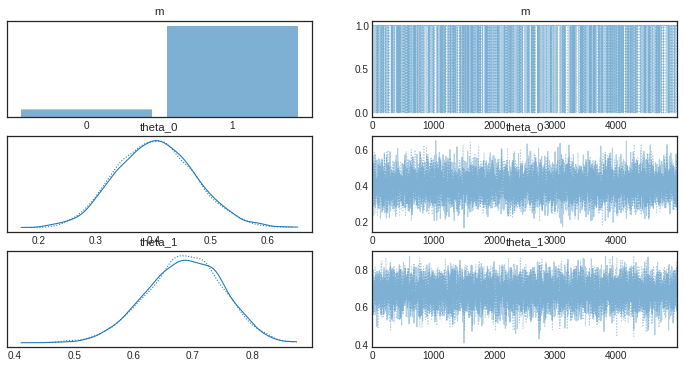

In [19]:
az.plot_trace(idata4);

In [20]:
trace4_df = idata4.posterior.to_dataframe().set_index('m')[['theta_0', 'theta_1']]
trace4_df.head()

,theta_0,theta_1
m,,
1,0.370912,0.659145
1,0.489963,0.679764
1,0.374542,0.752119
1,0.289301,0.559285
1,0.430541,0.801040


#### Figure 10.6 (lower part)

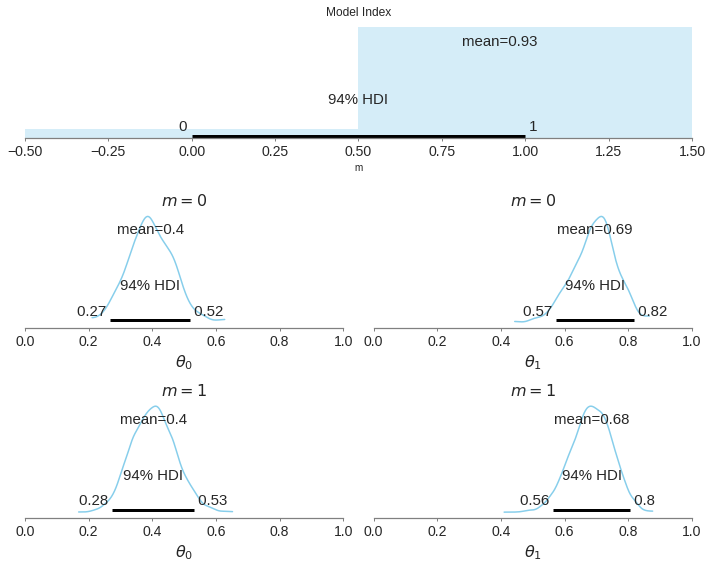

In [21]:
fig = plt.figure(figsize=(10,8))

# Define gridspec
gs = gridspec.GridSpec(3,2)
ax1 = plt.subplot(gs[0,:])
ax2 = plt.subplot(gs[1,0])
ax3 = plt.subplot(gs[1,1])
ax4 = plt.subplot(gs[2,0])
ax5 = plt.subplot(gs[2,1])

az.plot_posterior(np.asarray(trace4_df.index), ax=ax1, color=color)
ax1.set_xlabel('m')
ax1.set_title('Model Index')

for model, theta, ax in zip((0,0,1,1), (0,1,0,1), (ax2, ax3, ax4, ax5)):
    az.plot_posterior(trace4_df.loc[model, 'theta_{}'.format(theta)].values, ax=ax, color=color)
    ax.set_title(r'$m = {}$'.format(model), fontdict=font_d)
    ax.set_xlim(0,1)
    ax.set_xlabel(r'$\theta_{}$'.format(theta), fontdict=font_d)
    
fig.tight_layout();